In [1]:
#scientific libraries and plotting
import numpy as np
import scipy as scipy
from scipy import stats
from scipy.optimize import minimize
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak
from tqdm import tqdm

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution


LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
TEST_LABELS = [f"{label}" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT=True

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_15000_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

MODEL_NAME = "resnet_1687178683_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
LOAD_FOLDER = "../results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"


DEVICE = torch.device("cpu")
print("Running on the CPU")

ampl.use_atlas_style()   
paper_colors = sn.color_palette("deep", n_colors = len(LABELS))
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

Running on the CPU


In [4]:
#import model
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), padding_mode=circular)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_siz

In [5]:
#Load data
sph_testpath = [Path(TEST_DATAPATHS[0])]
sph_test_data = Hdf5Dataset(sph_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

bh_1_testpath = [Path(TEST_DATAPATHS[1])]
bh_1_test_data = Hdf5Dataset(bh_1_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

bh_2_testpath = [Path(TEST_DATAPATHS[2])]
bh_2_test_data = Hdf5Dataset(bh_2_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

bh_3_testpath = [Path(TEST_DATAPATHS[3])]
bh_3_test_data = Hdf5Dataset(bh_3_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

bh_4_testpath = [Path(TEST_DATAPATHS[4])]
bh_4_test_data = Hdf5Dataset(bh_4_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

bh_5_testpath = [Path(TEST_DATAPATHS[5])]
bh_5_test_data = Hdf5Dataset(bh_5_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.


In [6]:
x, y = bh_3_test_data[0]
print(y)

tensor([0., 0., 0., 1., 0., 0.], dtype=torch.float64)


In [7]:
"""
sph_truth, sph_preds = shuffle_predict(model, sph_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_1_truth, bh_1_preds = shuffle_predict(model, bh_1_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_2_truth, bh_2_preds = shuffle_predict(model, bh_2_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_3_truth, bh_3_preds = shuffle_predict(model, bh_3_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_4_truth, bh_4_preds = shuffle_predict(model, bh_4_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_5_truth, bh_5_preds = shuffle_predict(model, bh_5_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
"""

sph_truth, sph_preds, sph_values = shuffle_predict(model, sph_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_1_truth, bh_1_preds, bh_1_values = shuffle_predict(model, bh_1_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_2_truth, bh_2_preds, bh_2_values = shuffle_predict(model, bh_2_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_3_truth, bh_3_preds, bh_3_values = shuffle_predict(model, bh_3_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_4_truth, bh_4_preds, bh_4_values = shuffle_predict(model, bh_4_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_5_truth, bh_5_preds, bh_5_values = shuffle_predict(model, bh_5_test_data, CLASSES, 100, RES, DEVICE, return_values=True)


100%|██████████| 150/150 [01:27<00:00,  1.71it/s]


In [8]:
#Add data to dataframes
sph_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [sph_truth, sph_preds])))
bh_1_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_1_truth, bh_1_preds])))
bh_2_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_2_truth, bh_2_preds])))
bh_3_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_3_truth, bh_3_preds])))
bh_4_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_4_truth, bh_4_preds])))
bh_5_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_5_truth, bh_5_preds])))

datasets = [sph_df, bh_1_df, bh_2_df, bh_3_df, bh_4_df, bh_5_df]
output_values = [sph_values, bh_1_values, bh_2_values, bh_3_values, bh_4_values, bh_5_values]

keys = [f"class_{i}" for i in range(CLASSES)]
for i in range(CLASSES):
    for j in range(len(datasets)):
        datasets[i][keys[j]] = output_values[j][:, i]
    
print(bh_1_df.head())

   Truth  Predictions   class_0   class_1   class_2   class_3   class_4   class_5
0    1.0          4.0  0.002977  0.351151  0.178610  0.147017  0.016031  0.054782
1    1.0          2.0  0.065584  0.262450  0.090316  0.484578  0.008689  0.113504
2    1.0          5.0  0.107444  0.136092  0.173946  0.263910  0.344004  0.146304
3    1.0          2.0  0.052700  0.264083  0.038726  0.068394  0.302042  0.331246
4    1.0          1.0  0.066683  0.371176  0.011622  0.191489  0.020360  0.445134


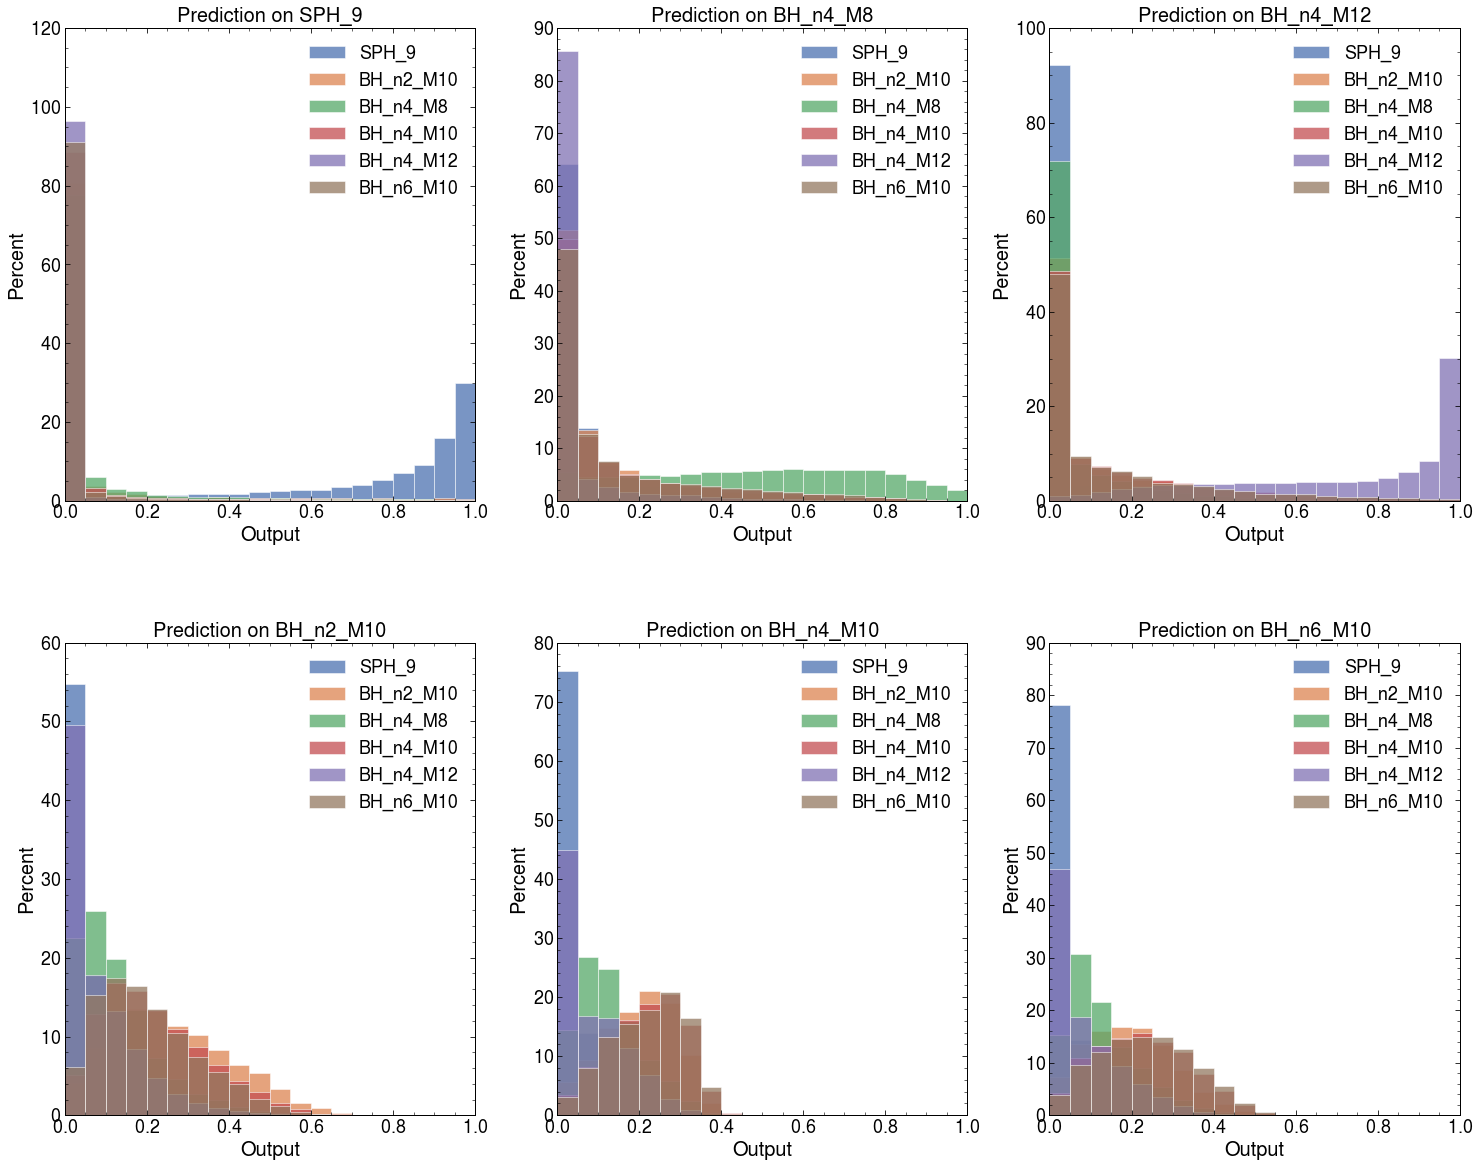

In [9]:
#Print the raw ML outputs before argmax
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
plt.subplots_adjust(hspace=0.3)
for i in range(CLASSES):
    for j in range(CLASSES):
        sn.histplot(datasets[i][f"class_{j}"], ax = ax[i%2][i//2], label=f"{PLOT_LABELS[j]}", color=paper_colors[j], binrange=[0, 1], bins=20, 
                    common_norm=False, multiple="layer", fill="False", stat="percent")
    ax[i%2][i//2].set_title(f"Prediction on {PLOT_LABELS[i]}")
    ax[i%2][i//2].legend()
    ax[i%2][i//2].set_xlim(0, 1)
    ax[i%2][i//2].set_xlabel("Output")


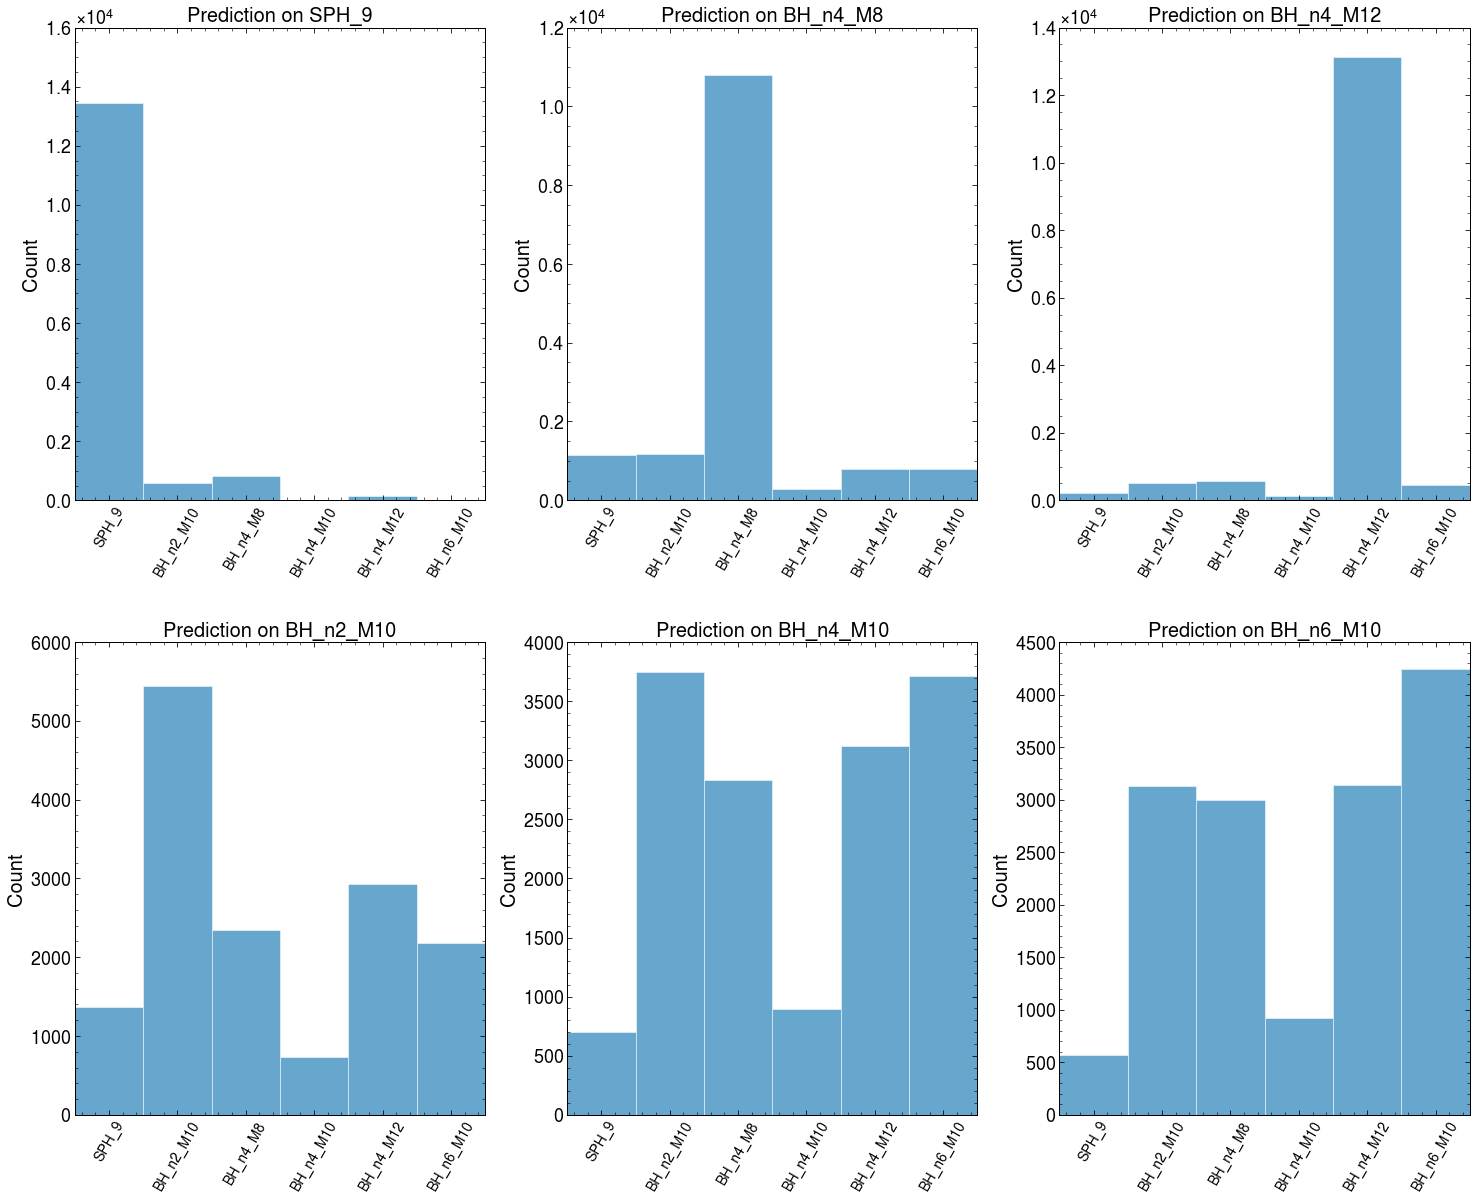

In [10]:
#Print the classifications
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
plt.subplots_adjust(hspace=0.3)
for i in range(CLASSES):
    sn.histplot(datasets[i]["Predictions"], binrange=[-0.5, CLASSES-0.5], bins=CLASSES, ax = ax[i%2][i//2])
    ax[i%2][i//2].set_title(f"Prediction on {PLOT_LABELS[i]}")
    ax[i%2][i//2].set_xticks(np.arange(0, CLASSES), PLOT_LABELS, rotation=60, fontsize=14)
    ax[i%2][i//2].set_xlabel("")
    ax[i%2][i//2].set_xlim(-0.5, CLASSES-0.5)


In [11]:
#Do this calculation just once
#Normalized prediction arrays for all datasets [hist1, hist2, ...] where hist1 = [a, b, c... d] with sum(hist1)=1
n_theory = [np.array([((len(theory[theory["Predictions"]==i])/len(theory))) for i in range(CLASSES)]) for theory in datasets]

In [12]:
#Chi2 test
def chi2(theory, data):
    return(np.sum((data-theory)**2/(theory)))

def chi2_method_pearson(theory, data, classes, verbose=False):

    #Number of classified particles in each class
    N_samp = len(data)
    #Number of predicted events for theory
    N_theory = theory*N_samp
    N_data = np.array([len(data[data["Predictions"]==i]) for i in range(classes)])
    #Calculate chi2_value
    chi2_value=chi2(N_theory, N_data)
    #Number of degrees of freedom
    ndof = classes-1
    #Get the p-value from the chi2
    p_value = np.float64((np.float64(1) - stats.chi2.cdf(chi2_value, ndof)))

    if verbose:
        #if p_value < 10**(-10):
        #print("p value: ", p_value)
        print(f"Histogram for data: {N_data}")
        print(f"Histogram theory: {N_theory}")
        print(f"The chi2 value for theory is {chi2_value}. The p-value is {p_value}")
    
    return p_value


In [13]:
data_id = 3
theory_id = 0
print(f"Sending in {PLOT_LABELS[data_id]}, testing against {PLOT_LABELS[theory_id]} theory")

N = 35 #number of events
k = np.random.randint(0, len(bh_2_df)-N)
experiment = datasets[data_id][k:k+N]
print("Detected events")
print(experiment)
print("..... Pearson chi2 test ....")
p2 = chi2_method_pearson(n_theory[theory_id], experiment, CLASSES, verbose=True)

Sending in BH_n4_M10, testing against SPH_9 theory
Detected events
      Truth  Predictions   class_0   class_1   class_2   class_3   class_4   class_5
2976    3.0          2.0  0.013734  0.338211  0.024284  0.143825  0.172924  0.369824
2977    3.0          1.0  0.049298  0.103822  0.088468  0.348232  0.147224  0.000036
2978    3.0          2.0  0.000937  0.143241  0.070448  0.138390  0.248214  0.336245
2979    3.0          1.0  0.170444  0.070074  0.143774  0.175830  0.166190  0.082572
2980    3.0          5.0  0.000551  0.267412  0.029474  0.283762  0.145934  0.104144
...     ...          ...       ...       ...       ...       ...       ...       ...
3006    3.0          5.0  0.024722  0.247980  0.171010  0.306303  0.014401  0.203611
3007    3.0          4.0  0.007376  0.288183  0.112841  0.174361  0.004094  0.372061
3008    3.0          3.0  0.003420  0.089980  0.138601  0.302689  0.009135  0.254997
3009    3.0          5.0  0.066396  0.154948  0.096997  0.328914  0.036635  0.33727

In [30]:
#p-value as a function of number of events
#p-value as a function of number of events
N_max = 35 #Maximum number of events measured
M = 1000 #Number of experiments to average
N_list = np.arange(2, N_max, 1) #A list of integers from 2 to N_max
norm_err = True

#RUN EXPERIMENT
"""
#Generate M random places in the dataset to start sampling
k_list = [np.random.randint(0, len(datasets[0])-N_max) for i in range(0, M)]

p_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))
err_up_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))
err_down_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))

for i in tqdm(range(len(datasets))): #Iterate over all types of pseudodata
    for s, sample in enumerate(n_theory): #Iterate over all theories/samples
        for j, n in enumerate(N_list): # Iterate over number of events detected
            experiments = [datasets[i][k:k+n] for k in k_list] #Generate a list of M number of experiments with n events
            results = np.array([chi2_method_pearson(sample, experiment, CLASSES) for experiment in experiments])
            mean = np.average(results, axis=0)
            results_up = results[results>=mean]
            results_down = results[results<mean]
            #print(mean, results_up, results_down)
            if mean > 0:
                if norm_err:
                    error_up = np.sqrt(1/len(results_up))*np.sqrt(((1/len(results_up))*np.sum((results_up - mean)**2)))
                    error_down = np.sqrt(1/len(results_down))*np.sqrt(((1/len(results_down))*np.sum((results_down - mean)**2)))
                else:
                    error_up = np.sqrt(((1/len(results_up))*np.sum((results_up - mean)**2)))
                    error_down = np.sqrt(((1/len(results_down))*np.sum((results_down - mean)**2)))
            else:
                error_up = 0
                error_down = 0
            p_values_p[i][s][j] = mean
            err_up_values_p[i][s][j] = error_up
            err_down_values_p[i][s][j] = error_down
"""

#LOAD EXPERIMENT

p_values_p = np.load("../results/chi2/chi_squared_results_resnet_1687178683_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT_M_3000_p_values.npy")
err_up_values_p = np.load("../results/chi2/chi_squared_results_resnet_1687178683_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT_M_3000_err_up_values.npy")
err_down_values_p = np.load("../results/chi2/chi_squared_results_resnet_1687178683_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT_M_3000_err_down_values.npy")


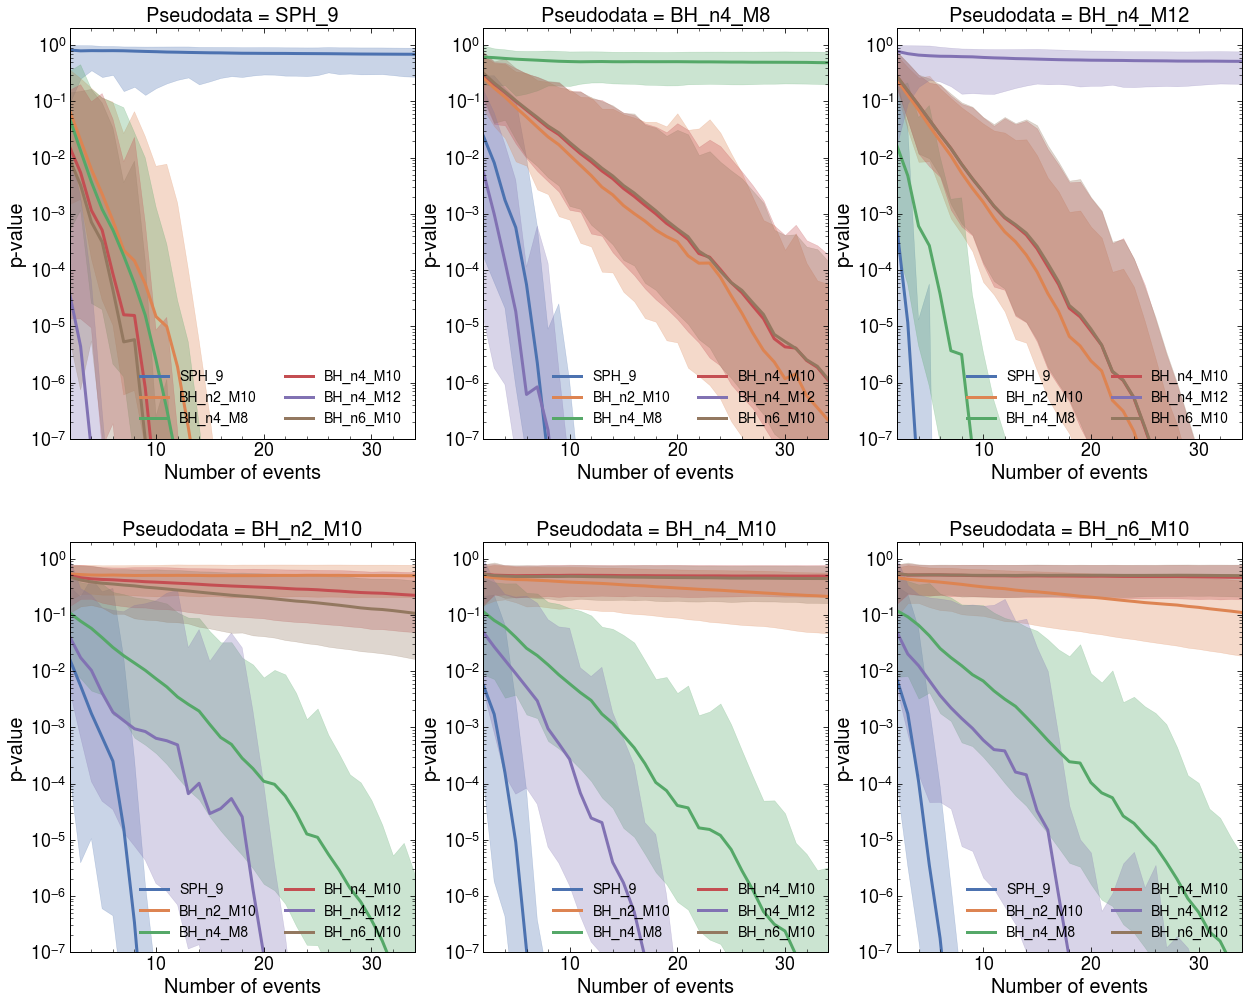

In [31]:

fig, ax = plt.subplots(ncols = 3, nrows=2, figsize=(21, 17))
plt.subplots_adjust(hspace=0.25)
for i in range(len(PLOT_LABELS)): #iterate over pseudodata
    ax[i%2][i//2].set_title(f"Pseudodata = {PLOT_LABELS[i]}")

    for j in range(len(PLOT_LABELS)): #iterate over theories
        ax[i%2][i//2].plot(N_list, p_values_p[i][j], label=PLOT_LABELS[j], color=paper_colors[j], linewidth=3)
        ax[i%2][i//2].fill_between(N_list, p_values_p[i][j] - err_down_values_p[i][j], p_values_p[i][j] + err_up_values_p[i][j], alpha=0.3, color=paper_colors[j])

for axis in ax.reshape(-1):
    axis.set_yscale("log")
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(2, N_max-1)
    axis.set_ylim(10**(-7), 2)
    axis.legend(loc=4, fontsize=14, ncol=2)

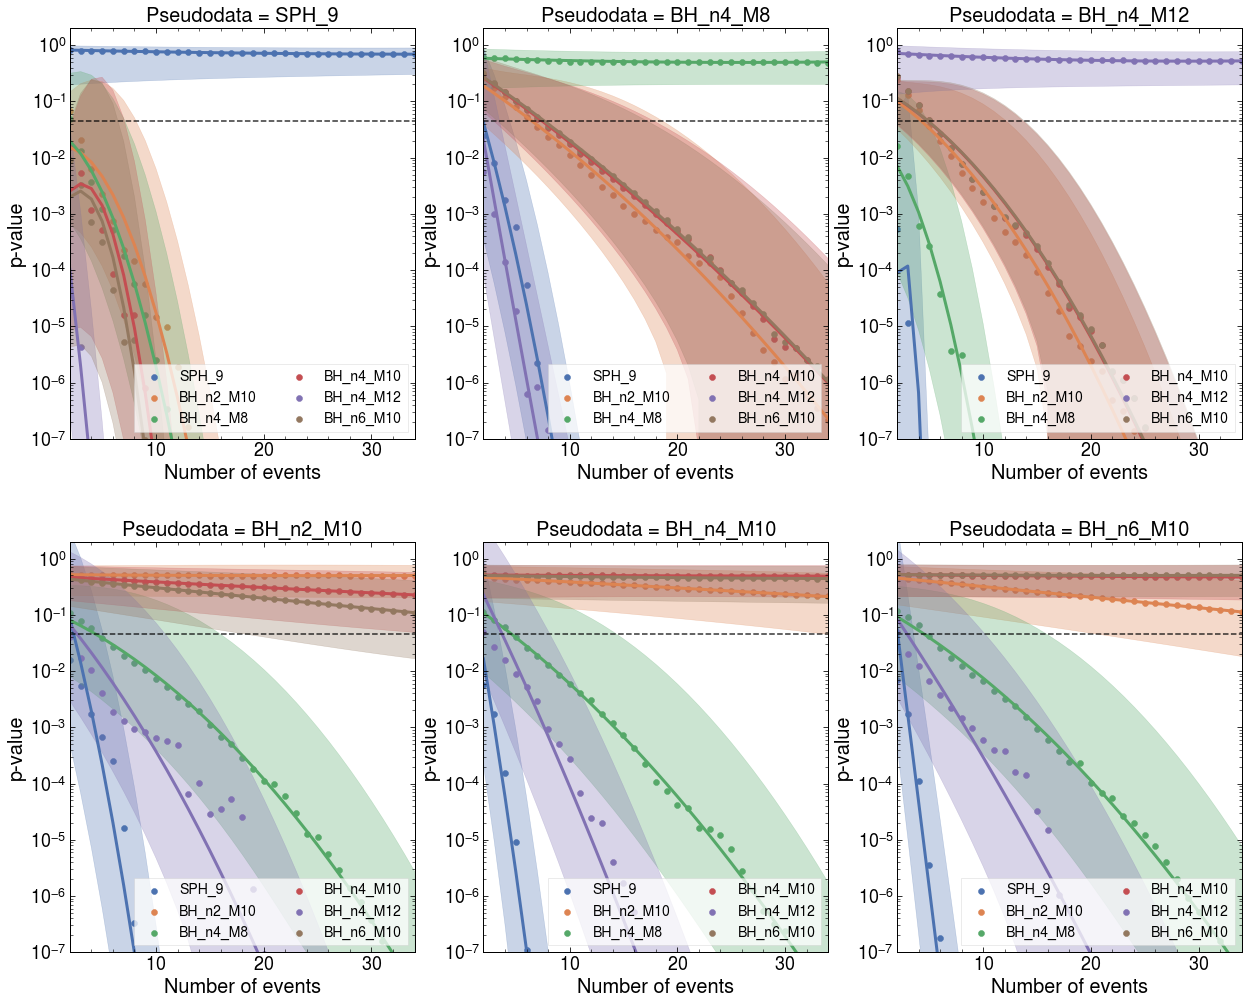

In [41]:
from scipy import optimize
def fit_func(x, a, b, c):
    return (-a*x**2-b*x-c)
 
fig, ax = plt.subplots(ncols = 3, nrows=2, figsize=(21, 17))
plt.subplots_adjust(hspace=0.25)

for i in range(len(PLOT_LABELS)): #iterate over pseudodata
    ax[i%2][i//2].set_title(f"Pseudodata = {PLOT_LABELS[i]}")

    for j in range(len(PLOT_LABELS)): #iterate over theories
        y_vals = p_values_p[i][j]
        x_vals = N_list[y_vals>0]
        err_down = err_down_values_p[i][j][y_vals>0]
        err_up = err_up_values_p[i][j][y_vals>0]
        y_vals = y_vals[y_vals>0]

        if len(y_vals)>0:
            
            y_params, y_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(y_vals), p0=[0, 0, 0], method='dogbox')
            err_down_params, err_down_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(err_down), p0=[0, 0, 0], method='dogbox')
            err_up_params, err_up_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(err_up), p0=[0, 0, 0], method='dogbox')

            fit_y_vals = np.exp(fit_func(x_vals, y_params[0], y_params[1], y_params[2]))
            fit_err_down = np.exp(fit_func(x_vals, err_down_params[0], err_down_params[1], err_down_params[2]))
            fit_err_up = np.exp(fit_func(x_vals, err_up_params[0], err_up_params[1], err_up_params[2]))
            
            #print(params)
            ax[i%2][i//2].scatter(x_vals, y_vals, label=PLOT_LABELS[j], color=paper_colors[j])
            ax[i%2][i//2].plot(x_vals, fit_y_vals, color=paper_colors[j], linewidth=3)
            ax[i%2][i//2].fill_between(x_vals, fit_y_vals - fit_err_down, fit_y_vals + fit_err_up, alpha=0.3, color=paper_colors[j])
        
        else:
            ax[i%2][i//2].scatter(x_vals, y_vals, label=PLOT_LABELS[j], color=paper_colors[j])

for axis in ax.reshape(-1):
    axis.set_yscale("log")
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(2, N_max-1)
    axis.set_ylim(10**(-7), 2)
    axis.legend(loc=4, fontsize=14, ncol=2, frameon=True)
    axis.plot(x_vals, [0.0455]*len(x_vals), color="black", linestyle="--", alpha=0.8)

In [26]:
#Save results as text file
np.set_printoptions(threshold=sys.maxsize)
with open(f"../results/chi_squared_results_{MODEL_NAME}_M_{M}.txt", "w") as f:
    f.write(f"Testing model {MODEL_NAME}. \n")
    f.write(f"Number of events in data: \n")
    f.write(f"{len(sph_df)} \n")
    f.write(f"Classes in data: \n")
    f.write(f"{CLASSES} \n")
    f.write(f"Number of events detected: \n")
    f.write(f"{N_list} \n")
    f.write(f"Number of samples for each n number of events: {M} \n")

    f.write(f"p_values: \n")
    f.write(f"{p_values_p} \n")
    f.write(f"Error up: \n")
    f.write(f"{err_up_values_p} \n")
    f.write(f"Error down: \n")
    f.write(f"{err_down_values_p} \n")
    f.close()


In [27]:
#Save results
np.save(f"../results/chi2/chi_squared_results_{MODEL_NAME}_M_{M}_p_values.npy", p_values_p)
if norm_err:
    np.save(f"../results/chi2/chi_squared_results_{MODEL_NAME}_M_{M}_norm_err_up_values.npy", err_up_values_p)
    np.save(f"../results/chi2/chi_squared_results_{MODEL_NAME}_M_{M}_norm_err_down_values.npy", err_down_values_p)
else:
    np.save(f"../results/chi2/chi_squared_results_{MODEL_NAME}_M_{M}_up_values.npy", err_up_values_p)
    np.save(f"../results/chi2/chi_squared_results_{MODEL_NAME}_M_{M}_down_values.npy", err_down_values_p)

In [28]:
#chi2 test kazuki
"""
def chi2_kazuki(o, m, s):
    return(np.sum((o-m)**2/(s**2)))

def chi2_method_kazuki(theory, data, classes, verbose=False):

    #Mean and std in each class for theory:
    t_mean  = np.mean(theory[keys].to_numpy(), axis=0)
    t_std = np.std(theory[keys].to_numpy(), axis=0)
    #Average for data
    d_mean = np.mean(data[keys].to_numpy(), axis=0)

    #Calculate chi2 value
    chi2_value = chi2_kazuki(d_mean, t_mean, t_std)

    #p-values
    p_value = np.float64((np.float64(1) - stats.chi2.cdf(chi2_value, classes-1)))

    if verbose:
        #print(f"{data.head()}")
        print(f"Data mean  : {np.round(d_mean, 2)}")
        print(f"Theory mean: {np.round(t_mean, 2)}")
        print(f"Theory std:  {np.round(t_std, 2)}")
        print(f"The chi2 is {chi2_value}. The p-value is {p_value}")

    return p_value

data_id = 2
theory_id = 0
print(f"Sending in {PLOT_LABELS[data_id]}, testing against {PLOT_LABELS[theory_id]} theory")

N = 5 #number of events
k = np.random.randint(0, len(bh_2_df)-N)
experiment = datasets[data_id][k:k+N]
print("Detected events")
print(experiment)
print("-----------------")
#experiment["Truth"] = data_id
print("..... Kazuki method ....")
p1 = chi2_method_kazuki(datasets[theory_id], experiment, CLASSES, verbose=True)
print("..... Wikipedia method ....")
p2 = chi2_method_pearson(datasets[theory_id], experiment, CLASSES, verbose=True)
"""

'\ndef chi2_kazuki(o, m, s):\n    return(np.sum((o-m)**2/(s**2)))\n\ndef chi2_method_kazuki(theory, data, classes, verbose=False):\n\n    #Mean and std in each class for theory:\n    t_mean  = np.mean(theory[keys].to_numpy(), axis=0)\n    t_std = np.std(theory[keys].to_numpy(), axis=0)\n    #Average for data\n    d_mean = np.mean(data[keys].to_numpy(), axis=0)\n\n    #Calculate chi2 value\n    chi2_value = chi2_kazuki(d_mean, t_mean, t_std)\n\n    #p-values\n    p_value = np.float64((np.float64(1) - stats.chi2.cdf(chi2_value, classes-1)))\n\n    if verbose:\n        #print(f"{data.head()}")\n        print(f"Data mean  : {np.round(d_mean, 2)}")\n        print(f"Theory mean: {np.round(t_mean, 2)}")\n        print(f"Theory std:  {np.round(t_std, 2)}")\n        print(f"The chi2 is {chi2_value}. The p-value is {p_value}")\n\n    return p_value\n\ndata_id = 2\ntheory_id = 0\nprint(f"Sending in {PLOT_LABELS[data_id]}, testing against {PLOT_LABELS[theory_id]} theory")\n\nN = 5 #number of event

In [29]:
"""

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
N_max = 35
M = 1000 #Number of experiments to average
N_list = np.arange(2, N_max, 1)
k_list = [[np.random.randint(0, len(datasets[0])-n) for i in range(0,M)] for n in N_list] #make a list of M random places to start sampling in the dataset

p_values = np.zeros((len(datasets), len(LABELS), len(N_list)))
err_up_values = np.zeros((len(datasets), len(LABELS), len(N_list)))
err_down_values = np.zeros((len(datasets), len(LABELS), len(N_list)))

for i in tqdm(range(len(datasets))): #Iterate over all types of pseudodata
    for s, sample in enumerate(datasets): #Iterate over all theories/samples
        for j, n in enumerate(N_list): # Iterate over number of events detected
            experiments = [datasets[i][k:k+n] for k in k_list[j]] #Get the samples
            results = np.array([chi2_method_kazuki(sample, experiment, CLASSES) for experiment in experiments]) #Evaluate the p-values
            #Calculate mean and errors
            mean = np.average(results, axis=0)
            results_up = results[results>=mean]
            results_down = results[results<mean]
            #Only evaluate errors if mean is not zero (values can not be less than zero)
            if mean > 0:
                error_up = np.sqrt((1/len(results_up)*np.sum((results_up - mean)**2)))
                error_down = np.sqrt((1/len(results_down)*np.sum((results_down - mean)**2)))
            else:
                error_up = 0
                error_down = 0
            #enter values in arrays
            p_values[i][s][j] = mean
            err_up_values[i][s][j] = error_up
            err_down_values[i][s][j] = error_down


fig, ax = plt.subplots(ncols = 3, nrows=2, figsize=(21, 17))
plt.subplots_adjust(hspace=0.25)
ax_2_max = 11
ax_2_id = np.argwhere(N_list >= ax_2_max)[0][0]

for i in range(len(PLOT_LABELS)): #iterate over pseudodata
    ax[i%2][i//2].set_title(f"Pseudodata = {PLOT_LABELS[i]}")
    
    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax[i%2][i//2], [0.5,0.3,0.45,0.45])
    ax2.set_axes_locator(ip)
    mark_inset(ax[i%2][i//2], ax2, loc1=2, loc2=4, fc="none", ec='0.5')
    
    for j in range(len(PLOT_LABELS)): #iterate over theories
        ax[i%2][i//2].plot(N_list, p_values_p[i][j], label=PLOT_LABELS[j], color=paper_colors[j], linewidth=3)
        ax[i%2][i//2].fill_between(N_list, p_values_p[i][j] - err_down_values_p[i][j], p_values_p[i][j] + err_up_values_p[i][j], alpha=0.3, color=paper_colors[j])
        # Mark the region corresponding to the inset axes on ax1 and draw lines
        # in grey linking the two axes.
        
        ax2.plot(N_list[0:ax_2_id], p_values_p[i][j][0:ax_2_id], label=PLOT_LABELS[j], color=paper_colors[j], linewidth=3)
        ax2.fill_between(N_list[0:ax_2_id], p_values_p[i][j][0:ax_2_id] - err_down_values_p[i][j][0:ax_2_id], p_values_p[i][j][0:ax_2_id] + err_up_values_p[i][j][0:ax_2_id], alpha=0.3, color=paper_colors[j])
        ax2.set_yscale("log")
        ax2.set_ylim(10**(-7), 10**(-2))
        ax2.set_xlim(2, N_list[ax_2_id]-1)
        ax2.set_xticks(np.arange(2, ax_2_max))
        

for axis in ax.reshape(-1):
    axis.set_yscale("log")
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(2, N_max-1)
    axis.set_ylim(10**(-7), 2)
    axis.legend(loc=4, fontsize=14, ncol=2)
"""

'\n\nfrom mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,\n                                                  mark_inset)\nN_max = 35\nM = 1000 #Number of experiments to average\nN_list = np.arange(2, N_max, 1)\nk_list = [[np.random.randint(0, len(datasets[0])-n) for i in range(0,M)] for n in N_list] #make a list of M random places to start sampling in the dataset\n\np_values = np.zeros((len(datasets), len(LABELS), len(N_list)))\nerr_up_values = np.zeros((len(datasets), len(LABELS), len(N_list)))\nerr_down_values = np.zeros((len(datasets), len(LABELS), len(N_list)))\n\nfor i in tqdm(range(len(datasets))): #Iterate over all types of pseudodata\n    for s, sample in enumerate(datasets): #Iterate over all theories/samples\n        for j, n in enumerate(N_list): # Iterate over number of events detected\n            experiments = [datasets[i][k:k+n] for k in k_list[j]] #Get the samples\n            results = np.array([chi2_method_kazuki(sample, experiment, CLASSES) fo